In [6]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xesmf as xe
import xclim.sdba as sdba

ValueError: format 'cf' already exists

<Axes: >

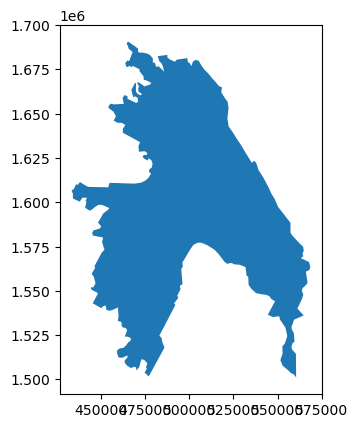

In [ ]:
file_in = "../data/Gezira_shapefile/Gezira.shp"
df_shapefile = gpd.read_file(file_in, crs="epsg:4326")
df_shapefile.plot()

In [ ]:
def mask_region(arr):
    arr = arr.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude")
    arr = arr.rio.write_crs("epsg:4326")
    return arr.rio.clip(df_shapefile.geometry.values, df_shapefile.crs, drop = False, invert = False)

In [ ]:
start, end = 1980, 2011
yrs = end - start
days = 365
tp_dat=np.empty((yrs, days))
rh_dat=np.empty((yrs, days))
t2m_dat=np.empty((yrs, days))

tp_dat[:]=np.nan
rh_dat[:]=np.nan
t2m_dat[:]=np.nan

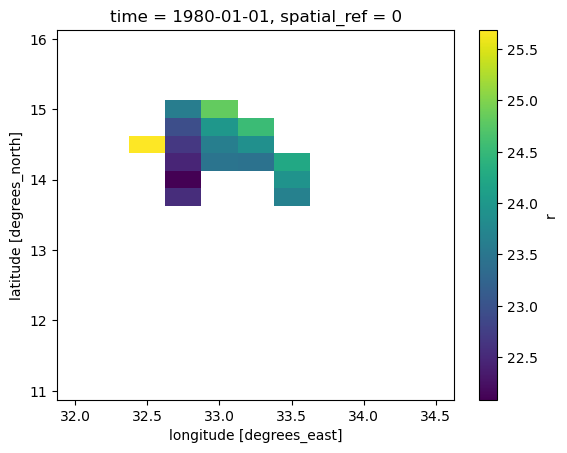

In [ ]:
# test
f_rh = xr.open_dataset(f"./data/era5_Geriza/RH/e5.RH.1000hPa.daily.1980.nc")
rh=mask_region(f_rh.r)
rh[0].plot()

In [ ]:
# open ERA5 data sample
for year in range(start,end):
    f_tp = xr.open_dataset(f"./data/era5_Geriza/precip/e5.precip.daily.{year}.nc")
    f_rh = xr.open_dataset(f"./data/era5_Geriza/RH/e5.RH.1000hPa.daily.{year}.nc")
    f_t2m = xr.open_dataset(f"./data/era5_Geriza/t2m/e5.t2m.daily.{year}.nc")
    j = year - start
    tp=f_tp.tp * 1000 # do unit conversion
    tp.attrs['units'] = 'mm/day' # update the unit attributes
    tp = mask_region(tp)
    rh=mask_region(f_rh.r)
    t2m=mask_region(f_t2m.t2m)
    for i in range(days):  # how to deal with leap years??
        tp_dat[j,i] = np.nanmean(tp[i,:,:])
        rh_dat[j,i] = np.nanmean(rh[i,:,:])
        t2m_dat[j,i] = np.nanmean(t2m[i,:,:])


In [ ]:
def plot(dat, title, unit):
    clim = np.nanmean(dat,axis=0)
    max=np.nanmax(dat,axis=0)
    min=np.nanmin(dat,axis=0)
    time=np.arange(days)
    plt.figure(figsize=(10,5))
    plt.plot(time,clim,label='ERA5')
    plt.fill_between(time,min,max,alpha=0.5)
    plt.grid()
    plt.xlim(0,364)
    plt.legend()
    plt.xlabel('Days since January 1st')
    plt.title(f'Mean Regional {title} Climatology {start}-{end-1} ({unit})')

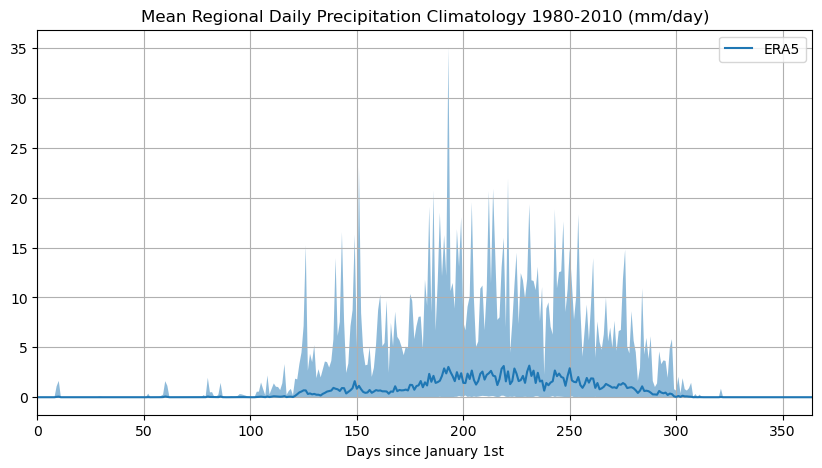

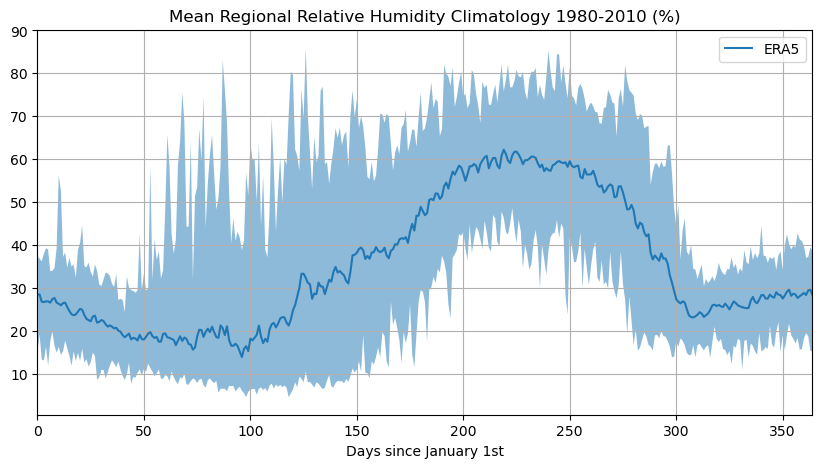

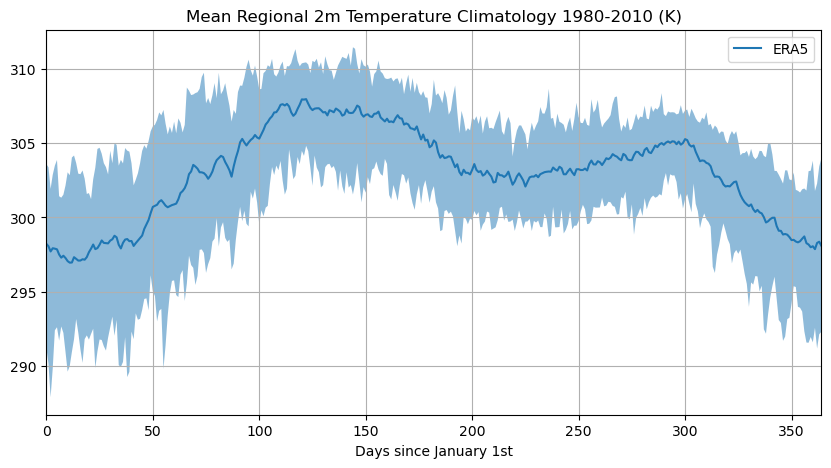

In [ ]:
plot(tp_dat, 'Daily Precipitation', 'mm/day')
plot(rh_dat, 'Relative Humidity', '%')
plot(t2m_dat, '2m Temperature', 'K')